In [1]:
#!pip install yfinance tensorflow scikit-learn pandas matplotlib joblib --quiet


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
symbol = "BTC-USD"
interval = "1m"   # Changé de 1m à 1h pour avoir plus de données stables
period = "7d"    # Changé de 7d à 60d pour avoir plus d'historique

df = yf.download(tickers=symbol, interval=interval, period=period)

if df.empty:
    raise ValueError(f"Aucune donnée téléchargée pour {symbol}")

print(f"{df.shape[0]} lignes téléchargées")
df.head()

C:\Users\soumayaj\AppData\Local\Temp\ipykernel_36672\2006681496.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=symbol, interval=interval, period=period)
[*********************100%***********************]  1 of 1 completed

7057 lignes téléchargées


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-10-17 00:02:00+00:00,108110.687500,108110.687500,108110.687500,108110.687500,0
2025-10-17 00:04:00+00:00,108036.765625,108036.765625,108036.765625,108036.765625,84795392
2025-10-17 00:06:00+00:00,108016.414062,108016.414062,108016.414062,108016.414062,12402688
2025-10-17 00:08:00+00:00,108083.031250,108083.031250,108083.031250,108083.031250,43540480
2025-10-17 00:09:00+00:00,108133.109375,108133.109375,108133.109375,108133.109375,27451392


In [4]:
#preprocessing
# # Utiliser seulement le prix de clôture comme dans TP_crypto.ipynb
#data = df[['Close']].astype('float32').values

# Normalisation sur toute la série (comme dans TP_crypto)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_normalized = scaler.fit_transform(data)

#print(f"Données normalisées: {data_normalized.shape}")

Données normalisées: (7057, 1)


In [ ]:
# === Prétraitement clair : split chronologique train/test et fit du scaler sur le train ===
# Features OHLCV
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].astype('float32').values  # shape (n_samples, n_features)

# Paramètres
look_back = 60   # fenêtre d'entrée
test_ratio = 0.2  # proportion pour test (chronologique)

n = len(data)
if n <= look_back + 2:
    raise ValueError("Pas assez de données pour la fenêtre look_back choisie")

# split chronologique simple (train = premières données, test = dernières données)
train_size = int(n * (1 - test_ratio))
train_data = data[:train_size]
test_data = data[train_size:]

# Scalers fit UNIQUEMENT sur le train
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# X = toutes les colonnes, y = Close
scaler_X.fit(train_data)
train_X = scaler_X.transform(train_data)
test_X = scaler_X.transform(test_data)

train_y = train_data[:, 3].reshape(-1, 1)  # Close column
test_y = test_data[:, 3].reshape(-1, 1)
scaler_y.fit(train_y)
train_y_scaled = scaler_y.transform(train_y)
test_y_scaled = scaler_y.transform(test_y)

print(f"N total={n}, train={train_X.shape[0]}, test={test_X.shape[0]}")
print(f"look_back={look_back}")

Formes : data=(7057, 5), train_X=(5645, 5), test_X=(1412, 5), data_X_normalized=(7057, 5)


In [ ]:
# === Generators : créer train_generator et test_generator propres ===
batch_size = 32

# train generator : X sequences -> y sequences (train)
train_generator = TimeseriesGenerator(
    train_X, train_y_scaled,
    length=look_back, sampling_rate=1, stride=1,
    batch_size=batch_size
)

# test generator : on veut évaluer uniquement sur la partie test
# mais TimeseriesGenerator requires sequences of length look_back, donc
# on doit fournir une X_test_sequences construite à partir de test_X.
# Pour que chaque test sample have a preceding look_back window, we need to
# include the last look_back rows from train in front of test to build the first test window.

X_for_test = np.vstack([train_X[-look_back:], test_X])
y_for_test = np.vstack([train_y_scaled[-look_back:], test_y_scaled])

test_generator = TimeseriesGenerator(
    X_for_test, y_for_test,
    length=look_back, batch_size=1
)

print('Train generator samples:', len(train_generator))
print('Test generator samples:', len(test_generator))

In [11]:
# === Définition du modèle LSTM ===
n_features = data.shape[1]
model = Sequential([
    LSTM(50, input_shape=(look_back, n_features)),
    Dense(1)  # prédire la valeur normalisée de Close
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



c:\Users\soumayaj\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Définition du modèle LSTM (léger) ===
from tensorflow.keras import regularizers
n_features = train_X.shape[1]
model = Sequential([
    LSTM(32, input_shape=(look_back, n_features), dropout=0.2, recurrent_dropout=0.1),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# === Entraînement avec validation sur test_generator for monitoring ===
epochs = 50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_generator, epochs=epochs, verbose=1, validation_data=test_generator, callbacks=[es, rlr])

# === Prédictions uniquement sur le test set ===
preds_norm = model.predict(test_generator)
preds = scaler_y.inverse_transform(preds_norm)

# récupérer vraies valeurs correspondantes (les y_for_test, mais en enlevant les look_back initial rows)
true_test = y_for_test[look_back:]
true_test_orig = scaler_y.inverse_transform(true_test)

# métriques sur test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_test = mean_squared_error(true_test_orig, preds)
mae_test = mean_absolute_error(true_test_orig, preds)
r2 = r2_score(true_test_orig, preds)
print(f"Test samples: {len(preds)}")
print(f"MSE_test: {mse_test:.4f}, MAE_test: {mae_test:.4f}, R2: {r2:.4f}")

# plot
plt.figure(figsize=(12,6))
plt.plot(true_test_orig, label='True (test)')
plt.plot(preds, label='Preds (test)')
plt.legend()
plt.title('Test set: True vs Preds')
plt.show()

# save model/scalers
model.save('lstm_ohlcv_close_light.h5')
from joblib import dump
dump(scaler_X, 'scaler_X.joblib')
dump(scaler_y, 'scaler_y.joblib')

Epoch 1/20


c:\Users\soumayaj\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0146
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0146
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4167e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4167e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3887e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3887e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0966e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0966e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1162e-04
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1162e-04
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7035e-04
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7035e-04
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2613e-04
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2613e-04
Epoch 8/20
175/175 ━━━━━━

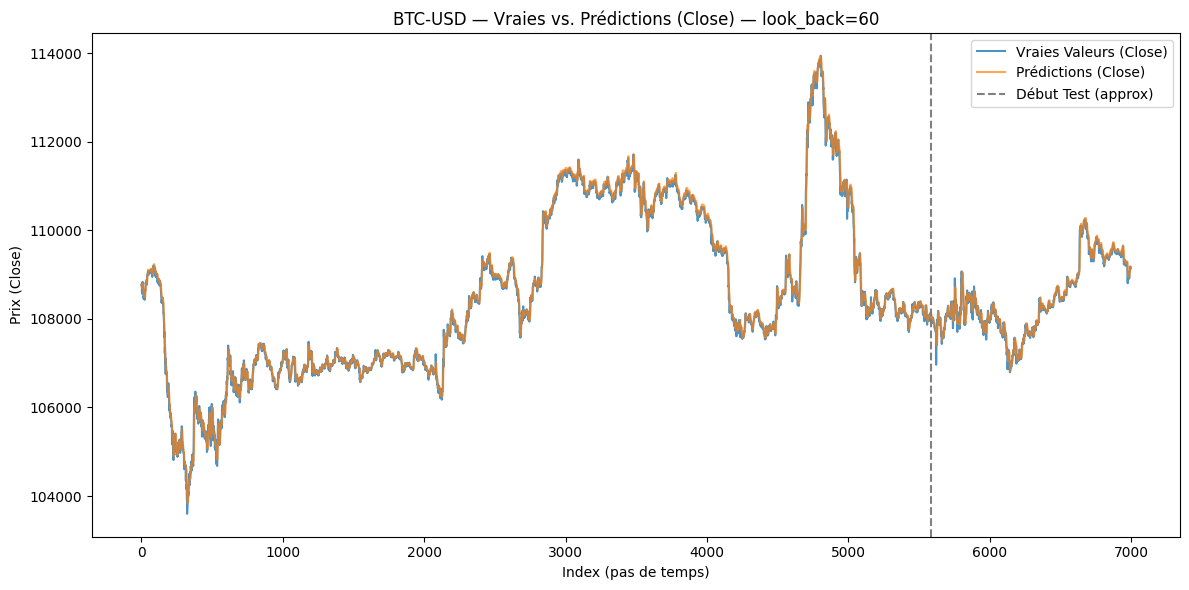

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(vraies_aligned, label='Vraies Valeurs (Close)', alpha=0.8)
plt.plot(predictions, label='Prédictions (Close)', alpha=0.7)
plt.axvline(x=train_size - look_back, color='gray', linestyle='--', label='Début Test (approx)')
plt.title(f"BTC-USD — Vraies vs. Prédictions (Close) — look_back={look_back}")
plt.xlabel('Index (pas de temps)')
plt.ylabel('Prix (Close)')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
#
# === Option : métriques strictes sur la partie TEST ===
# indices temporels absolus pour les prédictions : np.arange(look_back, look_back + n_preds_full)
pred_times = np.arange(look_back, look_back + n_preds_full)
# mask pour sélectionner ceux >= train_size
mask_test = pred_times >= train_size
preds_on_test = predictions[mask_test]
true_on_test = data[pred_times[mask_test], 3].reshape(-1, 1)
if len(preds_on_test) > 0:
    mse_test = np.mean((true_on_test - preds_on_test)**2)
    mae_test = np.mean(np.abs(true_on_test - preds_on_test))
    print(f"MSE (test): {mse_test:.4f}")
    print(f"MAE (test): {mae_test:.4f}")
else:
    print("Aucune prédiction dans la zone test (vérifiez look_back / train_ratio)")

# Sauvegarder le scaler et le modèle si besoin
# from joblib import dump
# dump(scaler_X, 'scaler_X_ohlcv.joblib')
# dump(scaler_y, 'scaler_y_close.joblib')
model.save('lstm_ohlcv_close.h5')


MSE (test): 10706.6768
MAE (test): 72.3448


Metrics (full):
 - mse: 11313.584961
 - rmse: 106.365337
 - mae: 74.490356
 - r2: 0.996282
 - mape_pct: 0.069%
Directional accuracy: 52.50%


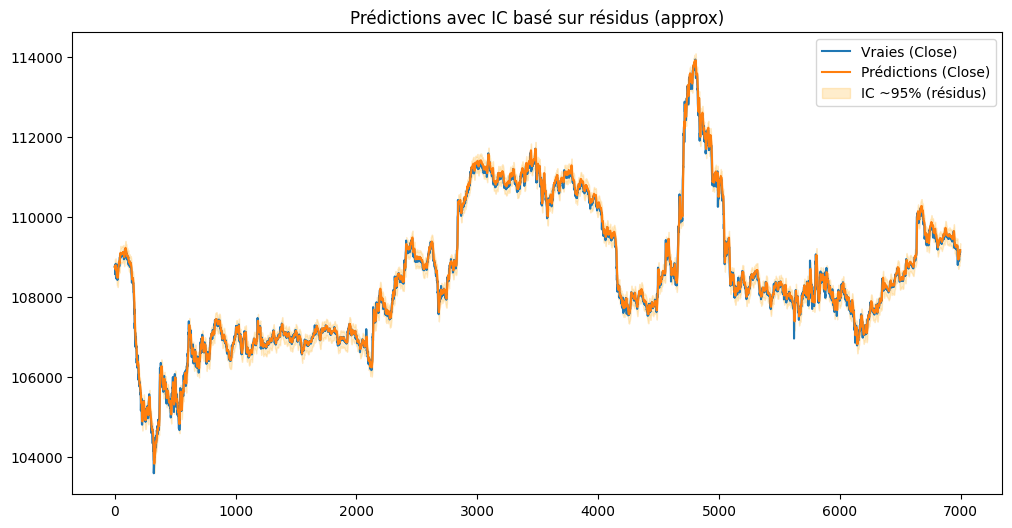

MC-dropout step skipped (model no dropout or incompatible shape). Error: module 'tensorflow.keras.backend' has no attribute 'function'
Evaluation cell executed at 2025-10-23 14:53:59.580502


In [15]:
# === Évaluation avancée et estimation d'incertitude ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Nous supposons que `predictions` et `vraies_aligned` existent (depuis la cellule précédente)
# predictions: shape (n_preds, 1), vraies_aligned: shape (n_preds, 1)

def regression_metrics(y_true, y_pred):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape_pct': mape}

metrics = regression_metrics(vraies_aligned, predictions)
print('Metrics (full):')
for k, v in metrics.items():
    if 'pct' in k:
        print(f" - {k}: {v:.3f}%")
    else:
        print(f" - {k}: {v:.6f}")

# Accuracy directionnelle : fréquence où on a bien prédit le sens du mouvement
# On compare delta(t) = price[t] - price[t-1] pour vraies et prédites
true_diff = np.diff(vraies_aligned.ravel())
pred_diff = np.diff(predictions.ravel())
# align lengths
minlen = min(len(true_diff), len(pred_diff))
direction_acc = np.mean(np.sign(true_diff[-minlen:]) == np.sign(pred_diff[-minlen:]))
print(f"Directional accuracy: {direction_acc*100:.2f}%")

# Intervalle de confiance basé sur les résidus (assume approx. normalité des erreurs)
residuals = (vraies_aligned - predictions).ravel()
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

alpha = 0.05
z = 1.96  # approx pour 95%
upper = predictions.ravel() + residual_mean + z * residual_std
lower = predictions.ravel() + residual_mean - z * residual_std

# Plot avec intervalles
plt.figure(figsize=(12, 6))
plt.plot(vraies_aligned, label='Vraies (Close)')
plt.plot(predictions, label='Prédictions (Close)')
plt.fill_between(np.arange(len(predictions)), lower, upper, color='orange', alpha=0.2, label='IC ~95% (résidus)')
plt.legend()
plt.title('Prédictions avec IC basé sur résidus (approx)')
plt.show()

# Optionnel — MC Dropout pour incertitude (nécessite des Dropout persistants à l'inférence):
# Si vous souhaitez utiliser MC-dropout, remplacez LSTM par une couche qui supporte dropout en inference
# et ré-entrainez. Exemple d'évaluation MC-dropout ci-dessous (exécuté seulement si model contient Dropout):
import tensorflow.keras.backend as K

def mc_dropout_predict(model, x_input, n_iter=50):
    # active training flag pour que dropout soit actif
    f = K.function([model.input, K.learning_phase()], [model.output])
    preds = []
    for _ in range(n_iter):
        p = f([x_input, 1])[0]
        preds.append(p)
    preds = np.stack(preds, axis=0)  # (n_iter, batch, 1)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std

# Exemple d'usage pour le test_generator (préparez X_test complet):
try:
    # construire X_test complet utilisé par full_generator (séquences)
    X_test = np.array([full_generator[i][0] for i in range(len(full_generator))])
    # X_test shape: (n_samples, 1, look_back, n_features) ou (n_samples, look_back, n_features)
    # adapter si nécessaire
    if X_test.ndim == 3:
        x_input = X_test
    else:
        x_input = X_test.reshape((X_test.shape[0],) + X_test.shape[-2:])

    mean_preds, std_preds = mc_dropout_predict(model, x_input, n_iter=30)
    mean_preds_rescaled = scaler_y.inverse_transform(mean_preds.reshape(-1, 1))
    std_preds_rescaled = std_preds.reshape(-1, 1) * (scaler_y.data_max_ - scaler_y.data_min_) / 2.0
    print('MC-dropout ready: mean and std shapes', mean_preds_rescaled.shape, std_preds_rescaled.shape)
except Exception as e:
    print('MC-dropout step skipped (model no dropout or incompatible shape). Error:', e)

# Mark todo completed
from datetime import datetime
print('Evaluation cell executed at', datetime.now())

# Update todo list: mark evaluation task completed

